In [23]:
###############################################################################
#          DÉBUT : IMPORTER LES LIBRAIRIES NÉCESSAIRES
###############################################################################
 
import time
import numpy as np
import matplotlib.pyplot as plt
# Pour créer une distribution normale multivariée
from scipy.stats import multivariate_normal
import ot
 
###############################################################################
#        FIN : IMPORTER LES LIBRAIRIES NÉCESSAIRES
###############################################################################

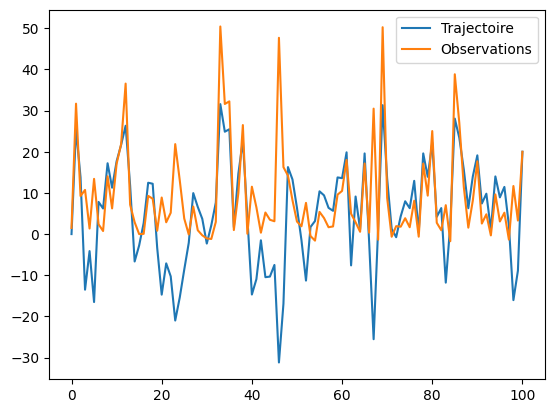

In [24]:
###############################################################################
#        DÉBUT : DÉFINIR ET SIMULER LE MODÈLE D'ÉTATS D'ESPACE
###############################################################################
# Simulation parameters
simTime = 100
x0 = 0
T = 50
Q = 10
R = 1

# Stockage de la trajectoire d'états
stateTrajectory = np.zeros(simTime+1)

# Mettre l'état initial
stateTrajectory[0] = x0

# Simuler le modèle
for i in range(simTime):
    stateTrajectory[i+1] = 0.5 * stateTrajectory[i] + 25 * (stateTrajectory[i] / (1 + stateTrajectory[i]**2)) + 8 * np.cos(1.2 * i) + np.random.normal(0, Q)
observations = ((stateTrajectory**2) / 20) + np.random.normal(0, R, len(stateTrajectory))

# Vérification visuelle
plt.plot(stateTrajectory, label='Trajectoire')
plt.plot(observations, label='Observations')
plt.legend()
plt.show()
###############################################################################
#        FIN : DÉFINIR, DISCRÉTISER ET SIMULER LE MODELE D'ÉTATS D'ESPACE
###############################################################################

In [25]:
numberIterations=50

noise_params = {'n': 0, 'Q': Q, 'R': R}
particles = np.random.randn(1000)  # Initial particles
weights = np.ones_like(particles) / len(particles)  # Initial uniform weights
print(len(particles))
state_estimates_classic = [x0]

def transition(particles, n, Q):
    return 0.5 * particles + 25 * particles / (1 + particles**2) + 8 * np.cos(1.2 * n) + np.random.normal(0, Q, size=particles.shape)

def likelihood_fn(particles, observation, R):
    predicted_observation = particles**2 / 20
    return np.exp(-0.5 * ((predicted_observation - observation) ** 2) / R)

#PARTIE À FAIRE
def reechantillonnage(particles, weights, temperature=1.0):
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    return particles[indices]
#PARTIE À FAIRE

for i in range(1, numberIterations+1):
    # STEP 1:
    # On échantillonne les états en utilisant la probabilité de transition, on applique le même input à chaque particule
    particles = transition(particles, noise_params['n'], noise_params['Q'])
    likelihood = likelihood_fn(particles, observations[i], noise_params['R'])
    
    # STEP 2: 
    weights = likelihood
    weights += 1e-300 
    weights = weights / np.sum(weights)
    state_estimate = np.sum(particles * weights)
     
    # STEP 3:     
    # On rééchantillonne par rapport aux probabilités des poids
    particles = reechantillonnage(particles, weights)
    weights = np.ones(len(particles)) / len(particles)
    state_estimates_classic.append(state_estimate)

1000


In [26]:
import numpy as np
import ot

numberIterations = 50
Q = 0.1  # Example process noise variance
R = 0.1  # Example observation noise variance
x0 = 0  # Example initial state
observations = np.random.randn(numberIterations + 1)  # Example observations
noise_params = {'n': 0, 'Q': Q, 'R': R}
particles = np.random.randn(1000)  # Initial particles
weights = np.ones_like(particles) / len(particles)  # Initial uniform weights
state_estimates_diff = [x0]

def transition(particles, n, Q):
    return (0.5 * particles +
            25 * particles / (1 + particles**2) +
            8 * np.cos(1.2 * n) +
            np.random.normal(0, Q, size=particles.shape))

def likelihood_fn(particles, observation, R):
    predicted_observation = particles**2 / 20
    return np.exp(-0.5 * ((predicted_observation - observation)**2) / R)

def optimal_transport_resampling(particles, weights):
    N = len(weights)
    target_weights = np.ones(N) / N  # Uniform distribution
    M = ot.dist(particles.reshape((N, 1)), particles.reshape((N, 1)))  # Cost matrix
    G = ot.sinkhorn(weights, target_weights, M, reg=2)  # Optimal transport plan
    resampled_indices = np.random.choice(N, size=N, p=np.sum(G, axis=1))
    return resampled_indices

def reechantillonnage(particles, weights):
    indices = optimal_transport_resampling(particles, weights)
    return particles[indices]

for i in range(1, numberIterations + 1):
    # STEP 1: Predict
    particles = transition(particles, noise_params['n'], noise_params['Q'])
    
    # STEP 2: Update weights
    weights = likelihood_fn(particles, observations[i], noise_params['R'])
    weights += 1e-300  # Avoid division by zero
    weights /= np.sum(weights)
    
    # Estimate state
    state_estimate = np.sum(particles * weights)
    state_estimates_diff.append(state_estimate)
    
    # STEP 3: Resample using optimal transport
    particles = reechantillonnage(particles, weights)
    weights.fill(1.0 / len(particles))

print(state_estimates_diff)


[0, -0.34266521282851453, -1.7954580381352325, -0.7760532465090293, -3.321472519661788, -2.986473209717391, 0.6251959552394597, 0.846974987171178, -0.027335709295409016, 5.3982441469874995, 14.754708437036495, 17.06856151003541, 17.989041326303873, 18.383342714589975, 18.55076619259556, 18.621489962262242, 18.651940652372254, 18.66143582184338, 18.669625486986032, 18.66882743484018, 18.667115852365807, 18.673436480748443, 18.66985415697159, 18.667881178943688, 18.660226000020096, 18.668873560258866, 18.668269728054582, 18.67262065270888, 18.675459136498787, 18.671116960580807, 18.67441153516664, 18.670137860631847, 18.674893389318672, 18.674280243630943, 18.664132179853972, 18.662271344540812, 18.668474720800575, 18.672177286404334, 18.675447278540695, 18.671973107668318, 18.667227507107057, 18.67109707262086, 18.668153571995546, 18.66746940634539, 18.66888984956941, 18.675288562271856, 18.676202495083704, 18.67407173187886, 18.68314655103016, 18.671685600760647, 18.671877680539247]


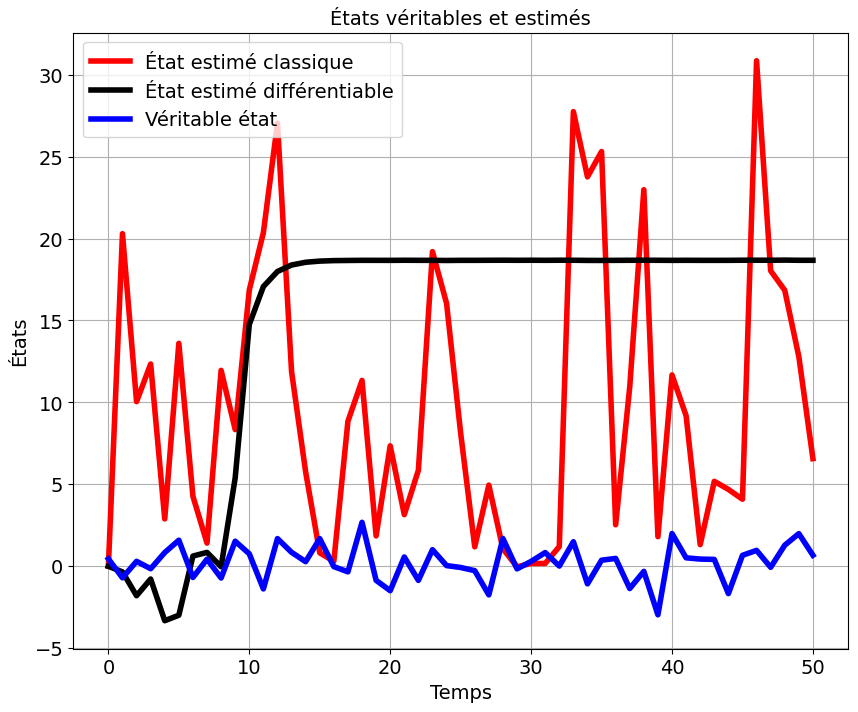

In [27]:
plt.figure(figsize=(10,8))
plt.plot(state_estimates_classic, color='red',linewidth=4, label='État estimé classique')
plt.plot(state_estimates_diff, color='black',linewidth=4, label='État estimé différentiable')
plt.plot(observations[0:51], color='blue',linewidth=4, label='Véritable état')
#plt.plot(stateTrajectory, color='green',linewidth=4, label='Trajectoire')

plt.title("États véritables et estimés", fontsize=14)
plt.xlabel("Temps", fontsize=14)
plt.ylabel("États",fontsize=14)
plt.tick_params(axis='both',which='major',labelsize=14)
plt.grid(visible=True)
plt.legend(fontsize=14)
plt.savefig("PFD.png",dpi=600)
plt.show()